In [79]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_44'

# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [80]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_rpy = np.load(stats_dir / 'base_rpy.npy')
    base_position = np.load(stats_dir / 'base_position.npy')
    base_velocity = np.load(stats_dir / 'base_velocity.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_rpy': base_rpy,
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [81]:
def plot_xy_coordinates(ax, stats):
    base_pos = stats['base_pos']
    xs = base_pos[:,0]
    ys = base_pos[:,1]

    ax.plot(xs, ys)
    ax.set_xlabel('Forward distance travelled (m)')
    ax.set_ylabel('Lateral deviation (m)')
    ax.axhline(0.0, color = 'black', alpha =0.3, linestyle='--')

def plot_heading(stats):
    base_pos = stats['base_pos']
    base_rpy = stats['base_rpy']
    xs = base_pos[:,0]
    yaws = base_rpy[:,2]

    plt.figure()
    plt.plot(xs, yaws)

def load_thrown_object_times():
    import csv
    obj_thrown_times = []
    with open('object_thrown_time.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            obj_thrown_times.append(row[0])
        return obj_thrown_times

In [82]:

statss = []
for seed in range(10):
    stats_dir = model_dir / f'throw-obj-long-platform-seed{seed}'
    stats = load_robot_states(stats_dir)
    stats['name'] = f'seed{seed}'
    statss.append(stats)

(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)


# Create plots of y-position, heading

/tmp/ipykernel_1294/4169528402.py:88: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("robustness_thrown_obj.pdf", format="pdf", bbox_layout="tight")


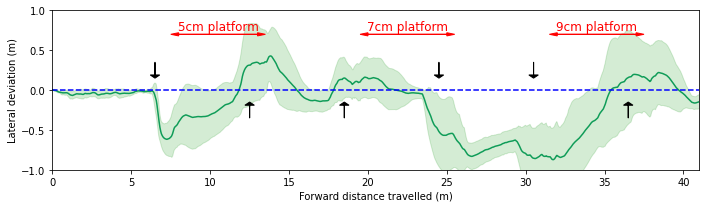

In [83]:
import matplotlib.pyplot as plt

NUM_TIMESTEPS = 200

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_red = (219 / 256, 68 / 256, 55 / 256, 1)
google_yellow = (244 / 256, 180 / 256, 0, 1)
google_green = (15 / 256, 157 / 256, 88 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_red, google_yellow, google_green]
obstacle_pos = [(7.5, 13.5), (19.5, 25.5), (31.5, 37.5)]
obstacle_names = ('5cm platform', '7cm platform', '9cm platform')
throw_directions = [-1, 1, 1, -1, -1, 1]
platform_heights = [0.05, 0.07, 0.09]

def plot_arrows(ax):
    ax.set_xlim(0, 41)
    ax.set_ylim(-1.0, 1.0)
    throw_idx = 0
    for i, (start, end) in enumerate(obstacle_pos):
        # ax.axvspan(start, end, color='gray', alpha=0.2)
        draw_spanning_arrow(ax, start, 0.7, end, 0.7, name=obstacle_names[i])
        #ax.axvline(start - 1, color = 'black', linestyle = '--')
        if throw_directions[throw_idx] == 1: 
            draw_up_arrow(ax, start)
        else: draw_down_arrow(ax, start)
        throw_idx += 1
        #ax.axvline(end - 1, color = 'black', linestyle = '--')
        if throw_directions[throw_idx] == 1: 
            draw_up_arrow(ax, end)
        else: draw_down_arrow(ax, end)
        throw_idx += 1
    
def draw_up_arrow(ax, x):
    ax.arrow(x -1, -0.35, 0, 0.2, length_includes_head=True, head_width=0.6, head_length=0.04, color='black')

def draw_down_arrow(ax, x):
    ax.arrow(x -1, 0.35, 0, -0.2, length_includes_head=True, head_width=0.6, head_length=0.04, color='black')

def draw_spanning_arrow(ax, x1, y1, x2, y2, name=""):
    xmid = (x1 + x2) / 2 
    ymid = (y1 + y2) / 2

    xdiff = xmid - x1 
    ydiff = ymid - y2

    ax.text(xmid, ymid + 0.1, name, horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
    ax.arrow(xmid, ymid, xdiff, ydiff, color='red', length_includes_head=True, head_width=0.04, head_length=0.5)
    ax.arrow(xmid, ymid, -xdiff, -ydiff, color='red', length_includes_head=True, head_width=0.04, head_length=0.5)


def plot_xy_coordinates(ax, stats):
    base_pos = stats['base_pos']
    xs = base_pos[:,0]
    ys = base_pos[:,1]

    ax.plot(xs, ys)
    ax.set_xlabel('Forward displacement (m)')
    ax.set_ylabel('Lateral displacement (m)')
    ax.axhline(0.0, color = 'black', alpha =0.3, linestyle='--')

def plot_xy_coordinates_distribution(ax, statss):
    xs = []
    ys = []
    for stats in statss:
        base_pos = stats['base_pos']
        xs.append(base_pos[:,0])
        ys.append(base_pos[:,1])
    xs=np.array(xs)
    ys=np.array(ys)
    
    x_mean = np.mean(xs, axis=0)
    x_std = np.std(xs, axis=0)
    y_mean = np.mean(ys, axis=0)
    y_std = np.std(ys, axis=0)

    ax.plot(x_mean, y_mean, color=google_green)
    ax.axhline(0.0, color = 'blue', linestyle='--')
    ax.fill_between(x_mean, y_mean + y_std, y_mean - y_std, color='tab:green', alpha=0.2)

fig, ax = plt.subplots(figsize=(10,3))
ax.set_xlabel('Forward distance travelled (m)')
ax.set_ylabel('Lateral deviation (m)')
plot_arrows(ax)
plot_xy_coordinates_distribution(ax, statss)
fig.tight_layout()
fig.savefig("robustness_thrown_obj.pdf", format="pdf", bbox_layout="tight")

AttributeError: 'list' object has no attribute 'items'

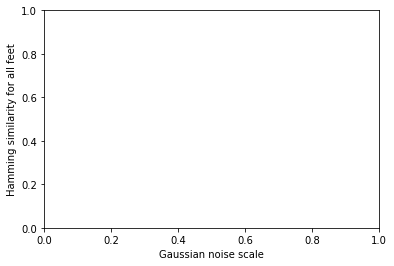

In [84]:
import matplotlib.pyplot as plt

NUM_TIMESTEPS = 200

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_red = (219 / 256, 68 / 256, 55 / 256, 1)
google_yellow = (244 / 256, 180 / 256, 0, 1)
google_green = (15 / 256, 157 / 256, 88 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_red, google_yellow, google_green]

def calc_hamming_sim(stats, by_foot=False):
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']

    # Divide by 2 since binary entries are [-1, 1] and not [0,1]
    diff = np.abs(ref_foot_contacts - act_foot_contacts) / 2
    hamming_dist = np.mean(diff, axis=0)
    if not by_foot:
        hamming_dist = np.mean(hamming_dist)
    hamming_sim = 1 - hamming_dist
    return hamming_sim

def plot_hamming_sim_dist(ax, noise_level, stats_collection):
    hamming_sims = []
    for seed, stats in stats_collection.items():
        hamming_sim = calc_hamming_sim(stats)
        print(noise_level, seed, hamming_sim)
        hamming_sims.append(hamming_sim)
    hamming_sims = np.array(hamming_sims)    

    ax.scatter([noise_level] * len(hamming_sims), hamming_sims)

def calc_vel_error(stats):
    target_vel = stats['']
    actual_vel = stats['base_velocity']


def plot_velocity_err_dist(ax, noise_level, stats_collection):
    hamming_sims = []
    for seed, stats in stats_collection.items():
        hamming_sim = calc_hamming_sim(stats)
        print(noise_level, seed, hamming_sim)
        hamming_sims.append(hamming_sim)
    hamming_sims = np.array(hamming_sims)    

    ax.scatter([noise_level] * len(hamming_sims), hamming_sims)

fig, ax = plt.subplots()
ax.set_xlabel("Gaussian noise scale")
ax.set_ylabel("Hamming similarity for all feet")
# ax.set_ylim(0, 1.1)

for noise_level, stats_collection in statss.items():
    plot_hamming_sim_dist(ax, noise_level, stats_collection)
    #for seed, stats in stats_collection.items():
    #    hamming_sim = calc_hamming_sim(stats)
    #    print(noise_level, seed, hamming_sim)

fig.savefig("with_sensor_noise.pdf", format="pdf", bbox_layout="tight")